In [49]:
import json
import os
import glob

def extract_json_from_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    json_part = content.split('Done!')[1].strip()
    data = json.loads(json_part)
    return data

def load_all_json_files(directory, numOfConnections):
    json_data_list = []
    pattern = os.path.join(directory, f'result-{numOfConnections}-*')
    for file_path in glob.glob(pattern):
        json_data = extract_json_from_file(file_path)
        json_data_list.append(json_data)
    return json_data_list

In [177]:
import pandas as pd

def load_df(numOfConnections, server):
    directory = 'results/' + server
    results = [data for data in load_all_json_files(directory, numOfConnections)]
    df = pd.json_normalize(results)
    df = df[[
        'result.req1xx',
        'result.req2xx',
        'result.req3xx',
        'result.req4xx',
        'result.req5xx',
        'result.others',
        'result.rps.mean',
        'result.rps.stddev',
        'result.rps.percentiles.50',
        'result.rps.percentiles.75',
        'result.rps.percentiles.90',
        'result.rps.percentiles.95',
        'result.rps.percentiles.99',
        'result.latency.mean',
        'result.latency.stddev',
        'result.latency.max',
    ]]
    df['result.latency.mean'] = df['result.latency.mean'] / 1000
    df['result.latency.stddev'] = df['result.latency.stddev'] / 1000
    df['result.latency.max'] = df['result.latency.max'] / 1000
    
    df = df.iloc[5:]
    return df

In [178]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
        
def plot_latency(ax, df):
    mean_values = df['result.latency.mean']
    stddev_values = df['result.latency.stddev']

    upper_bound = mean_values + stddev_values
    lower_bound = mean_values

    ax.plot(mean_values, label='mean', color='blue')
    ax.fill_between(range(len(mean_values)), lower_bound, upper_bound, color='blue', alpha=0.2, label='stddev')

    ax.set_ylabel('Latency in ms')
    ax.legend(fontsize='7', bbox_to_anchor=(1.05, 1), loc='upper left')

def plot_rps(ax, df):
    mean_values = df['result.rps.mean']
    stddev_values = df['result.rps.stddev']
    p95_values = df['result.rps.percentiles.95']
    p99_values = df['result.rps.percentiles.99']

    upper_bound = mean_values + stddev_values
    lower_bound = mean_values - stddev_values

    ax.plot(mean_values, label='mean', color='blue')
    ax.fill_between(range(len(mean_values)), lower_bound, upper_bound, color='blue', alpha=0.2, label='stddev')
    ax.plot(p95_values, label='p95', color='green', linestyle='--')
    ax.plot(p99_values, label='p99', color='red', linestyle='--')

    ax.set_ylabel('Requests per minute')
    ax.legend(fontsize='7', bbox_to_anchor=(1.05, 1), loc='upper left')
    
def plot_req_status(ax, df):
    req1xx = df['result.req1xx']
    req2xx = df['result.req2xx']
    req3xx = df['result.req3xx']
    req4xx = df['result.req4xx']
    req5xx = df['result.req5xx']
    others = df['result.others']

    ax.plot(req1xx, label='1xx', color='blue')
    ax.plot(req2xx, label='2xx', color='green')
    ax.plot(req3xx, label='3xx', color='yellow')
    ax.plot(req4xx, label='4xx', color='orange')
    ax.plot(req5xx, label='5xx', color='red')
    ax.plot(others, label='others', color='black')

    ax.set_xlabel('Runs')
    ax.set_ylabel('Requests per minute')
    ax.legend(fontsize='7', bbox_to_anchor=(1.05, 1), loc='upper left')

colors = ['darkcyan', 'darkblue', 'darkred', 'darkorange', 'darkgreen', 'darkmagenta', 'darkolivegreen', 'darkorchid', 'darkgoldenrod', 'darkslategray']
def plot_latency_all(ax, dfs):
    for i, (name, df) in enumerate(dfs.items()):
        latency_means = df['result.latency.mean']
        
        ax.plot(latency_means, label=f'{name} mean', color=colors[i])
    
    # ax.set_ylabel('Latency in ms')
    # ax.legend(fontsize='7', bbox_to_anchor=(1.05, 1), loc='upper left')

def plot_rps_all(ax, dfs):
        for i, (name, df) in enumerate(dfs.items()):
            rps_means = df['result.rps.mean']
            p95_values = df['result.rps.percentiles.95']
            ax.plot(rps_means, label=f'{name} rpc', color=colors[i])
        
        # ax.set_ylabel('Requests per minute')
        # ax.legend(fontsize='7', bbox_to_anchor=(1.05, 1), loc='upper left')

In [205]:

def show_benchmark(numOfConnections, server):
    fig, axs = plt.subplots(3, 1, figsize=(6, 4), sharex=True)
    fig.suptitle(f'Benchmark Results {server} for {numOfConnections} connection')
    df = load_df(numOfConnections, server)
    plot_latency(axs[0], df)
    plot_rps(axs[1], df)
    plot_req_status(axs[2], df)

def show_benchmarks(connections, scenarios):
    fig, axs = plt.subplots(nrows=len(connections), ncols=2, figsize=(8, 6), sharex=True)
    for i, connection in enumerate(connections):
        dfs = {name : load_df(connection, scenario) for name, scenario in scenarios.items()}
        plot_latency_all(axs[i][0], dfs)
        plot_rps_all(axs[i][1], dfs)
        axs[i][0].set_title(f'{connection} connections', fontdict = {'fontsize': 12, 'ha': 'center'})
        # fig.text(0.5, 1 - (i + 0.5) / 4, f'{connection} connections', ha='center', va='center', fontsize=12)
    plt.tight_layout()
    fig.text(0.5, -0.01, 'Iteration', ha='center')
    fig.text(0.01, 0.5, 'Latency in ms', va='center', rotation='vertical')
    fig.text(1.01, 0.5, 'Requests per min', va='center', rotation='vertical')
    fig.legend(scenarios.keys(), loc='center left', bbox_to_anchor=(0.05, -0.1), fontsize=10)
    plt.savefig('benchmark_chart.png', dpi=300, bbox_inches='tight')



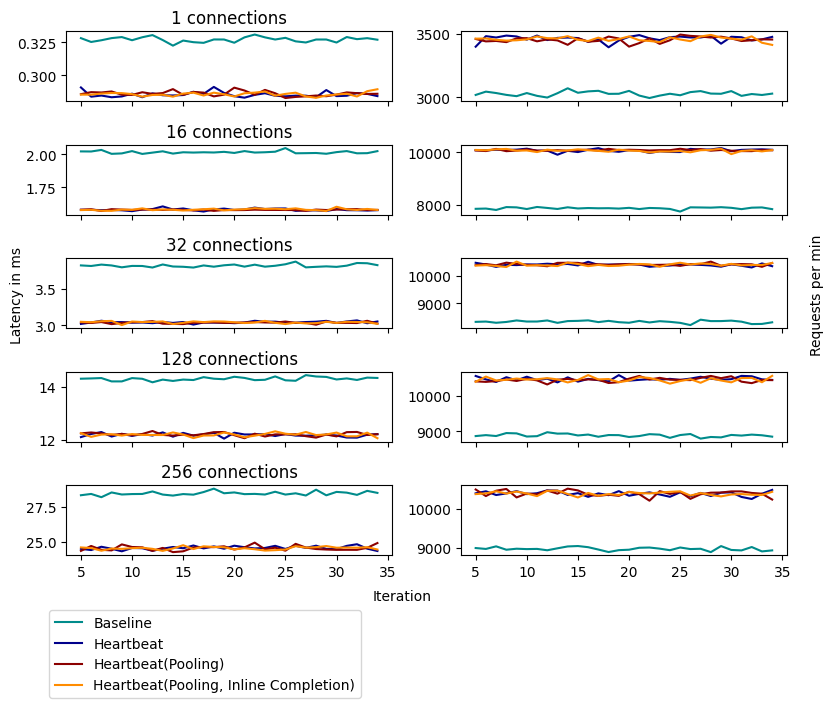

In [206]:
scenarios = { 
             'Baseline': 'unix_baseline', 
             'Heartbeat': 'unix_heartbeat', 
             'Heartbeat(Pooling)': 'unix_heartbeat_pool', 
             'Heartbeat(Pooling, Inline Completion)': 'unix_heartbeat_pool_inline' 
             }
show_benchmarks([1, 16, 32, 128, 256], scenarios)
